In [4]:
import torch
import tal
import numpy as np

from torch import optim as optimizers

from model.nerf import NLOSNeRF
from model.scene import Scene
from model.context import NeRFContext
from matplotlib import pyplot as plt

In [3]:
logseq = torch.logspace(start=0, end=4, steps=5, base=2).float()
logseq

tensor([ 1.,  2.,  4.,  8., 16.])

In [3]:
center = np.array([0, 0, 0.5])
model = NLOSNeRF(positional_encoding=True, ignore_albedo=True).to(device="cuda:1")
dict_ = torch.load("./data/models/T-single-oneshot-integrator-nrho-32-b16-finetuned.pth")
model.load_state_dict(dict_["model_state_dict"])
dx = 1 / np.sqrt(2)
dy = 1 / np.sqrt(2)
dz = 1 / np.sqrt(2)
xv = torch.linspace(start=center[0]+(dx/2), end=center[0]-(dx/2), steps=64)
yv = torch.linspace(start=center[1]+(dy/2), end=center[1]-(dy/2), steps=64)
zv = 0.5*torch.ones((64, 64))
X, Y = torch.meshgrid(xv, yv, indexing="ij")
stack_pts = torch.stack((X, Y, zv), axis=-1)
stack_dirs = (torch.pi / 2) * torch.ones((64, 64, 2))
stack_input = torch.cat((stack_pts, stack_dirs), dim=-1)
with torch.no_grad():
    result = model(model.fourier_encoding(stack_input).to(device="cuda:1"))

FileNotFoundError: [Errno 2] No such file or directory: './data/models/T-single-oneshot-integrator-nrho-32-b16-finetuned.pth'

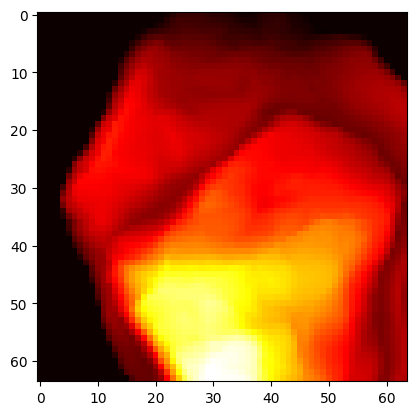

In [11]:
fig, ax = plt.subplots()
pred = torch.prod(result, dim=-1).detach().cpu().numpy()
ax.imshow(pred, cmap="hot")

In [3]:
def get_volume(nx, ny, center):
    """_summary_

    Args:
        nx (_type_): _description_
        ny (_type_): _description_
    """
    dx = 1 / np.sqrt(2)
    dy = 1 / np.sqrt(2)
    dz = 1 / np.sqrt(2)
    xv = np.linspace(start=center[0]-dx/2, stop=center[0]+dx/2, num=nx)
    yv = np.linspace(start=center[1]-dy/2, stop=center[1]+dy/2, num=ny)
    zv = np.linspace(start=center[2]-dz/2, stop=center[2]+dz/2, num=nx)
    X, Y, Z = np.meshgrid(xv, yv, zv)
    return np.stack((X, Y, Z), axis=-1)

In [4]:
path = "./data/Z-scene/Z-scene.hdf5"
gt_data = tal.io.read_capture(path)
tal.reconstruct.compensate_laser_cos_dsqr(gt_data)
gt_H = torch.from_numpy(gt_data.H)
center = np.array([0, 0, 0.5])
volume_xyz = get_volume(32, 32, center=center)

In [5]:
torch.where(gt_H > 0)

(tensor([ 20,  20,  20,  ..., 198, 198, 200]),
 tensor([ 8,  8,  8,  ..., 30, 31, 31]),
 tensor([ 8,  9, 10,  ..., 31, 30, 31]))

In [6]:
with tal.resources(8):
    rec = tal.reconstruct.fbp.solve(
        data=gt_data,  volume_xyz=volume_xyz, wl_mean=0.2, wl_sigma=0.2
    )

tal.reconstruct.filter_H: Using wavelengths from 0.1325m to 0.4081m
tal.resources: Using 8 CPU processes and downscale 8.


tal.resources progress: 100%|██████████| 8/8 [00:00<00:00, 529.15it/s]            

tal.reconstruct.utils: Assuming that volume_xyz is X_Y_Z_3


tal.resources: Using 8 CPU processes and downscale 8.


tal.resources progress: 100%|██████████| 8/8 [00:01<00:00,  7.08it/s]


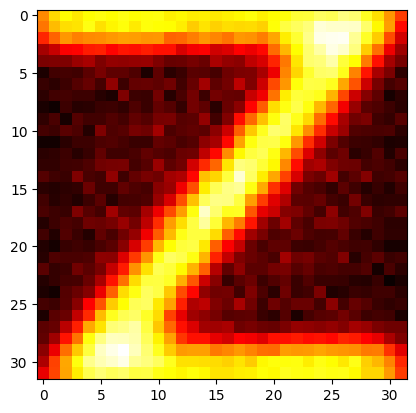

In [7]:
plt.imshow(np.sum(np.abs(rec), axis=-1), cmap="hot")